## Prediction using RNN

In [1]:
import torch

In [2]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Define the RNN model
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DeepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [4]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample


In [5]:
# Read data from CSV
force_data = pd.read_csv('ForceData_Evraz1.csv')

In [6]:
force_data.columns

Index(['slabid', 'last_pass_dat', 'last_pass_tim', 'htnr', 'mold', 'csnr',
       'work_top_diam', 'work_bot_diam', 'work_top_crown', 'work_bot_crown',
       'backup_top_diam', 'backup_bot_diam', 'tot_rolled_wr_len',
       'tot_rolled_br_len', 'model_grade', 'ordered_gauge', 'target_gauge',
       'model_target_gauge', 'meas_final_gauge', 'op_gauge_bias',
       'op_shape_bias', 'op_bend_bias', 'op_crown_bias', 'xray_slow_adjust',
       'opr_gap_trim', 'ordered_width', 'number_of_passes',
       'nr_passes_measured', 'pass_number', 'sch_mill_draft',
       'sch_exit_thickness', 'sch_crown', 'sch_exit_width', 'sch_head_force',
       'orig_pred_force', 'meas_head_force', 'meas_body_force',
       'roll_bending_force', 'meas_bend_force', 'pred_exit_temp',
       'meas_exit_temp', 'profile_xray_crown', 'profile_xray_wedge',
       'lstpass_hend_gm_ga', 'lst_gm_ga_avg', 'lst_gm_ga_min', 'lst_gm_ga_max',
       'lst_gm_ga_std', 'lst_gm_ga_num', 'lst_gm_ga_min_loc',
       'lst_gm_ga_max_

In [7]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(force_data[['meas_body_force','meas_exit_temp']])

In [8]:
# Define train-test split (80-20)
train_size = int(0.8 * len(scaled_data))
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [9]:
# Define hyperparameters
input_size = 2
hidden_size = 64
num_layers = 2
output_size = 2
num_epochs = 100
batch_size = 32
learning_rate = 0.001

In [10]:
# Prepare DataLoader
train_dataset = CustomDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# Initialize the model, loss function, and optimizer
model = DeepRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DeepRNN(
  (rnn): RNN(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [13]:
# Training the model
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        inputs = data[:, :-1].view(-1, 1, input_size).float().to(device)
        targets = data[:, -1].view(-1, output_size).float().to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0059
Epoch [20/100], Loss: 0.0893
Epoch [30/100], Loss: 0.0064
Epoch [40/100], Loss: 0.0049
Epoch [50/100], Loss: 0.0061
Epoch [60/100], Loss: 0.0051
Epoch [70/100], Loss: 0.0031
Epoch [80/100], Loss: 0.0044
Epoch [90/100], Loss: 0.0082
Epoch [100/100], Loss: 0.0102


In [14]:
# Test the model
model.eval()
with torch.no_grad():
    inputs = torch.Tensor(test_data[:, :-1]).view(-1, 1, input_size).to(device)
    targets = torch.Tensor(test_data[:, -1]).view(-1, output_size).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    print(f'Test Loss: {loss.item():.4f}')

Test Loss: 0.0046


In [15]:
# Denormalize the predictions
predicted_values = scaler.inverse_transform(outputs.cpu().numpy())

In [16]:
print(predicted_values)

[[4751.717  1659.8116]
 [4738.348  1654.7292]
 [4792.1797 1675.1982]
 ...
 [4733.817  1655.8323]
 [4740.6323 1680.3369]
 [4799.046  1728.0062]]


In [17]:
#Force Values
predicted_values[:,0]

array([4751.717 , 4738.348 , 4792.1797, 4774.2417, 4716.2803, 4700.4644,
       4970.463 , 4595.181 , 4685.5527, 4601.854 , 4536.1494, 4563.2446,
       4566.602 , 4654.4663, 4616.081 , 4625.677 , 4565.544 , 4638.041 ,
       4538.864 , 4527.541 , 4639.364 , 4709.0615, 4768.811 , 4768.7607,
       4834.297 , 4817.0005, 4817.0005, 4794.885 , 4794.885 , 4786.379 ,
       4786.378 , 4787.9263, 4773.7246, 4773.714 , 4755.217 , 4699.666 ,
       4699.9287, 4773.2075, 4744.062 , 4744.02  , 4727.167 , 4779.151 ,
       4779.1265, 4742.115 , 4708.4097, 4655.1626, 4655.4507, 4700.0576,
       4653.3267, 4720.1367, 4719.9463, 4677.4316, 4698.942 , 4711.4077,
       4717.5337, 4720.528 , 4717.174 , 4952.7227, 4627.7393, 4617.1743,
       4720.295 , 4694.8604, 4655.1475, 4740.9697, 4706.307 , 4702.585 ,
       4627.8374, 4905.5737, 4874.8257, 4875.1855, 4685.926 , 4642.2114,
       4665.6304, 4724.4346, 4415.9473, 4649.651 , 4649.561 , 4637.8545,
       4640.9834, 4682.152 , 4679.7134, 4460.7173, 

In [18]:
import matplotlib.pyplot as plt

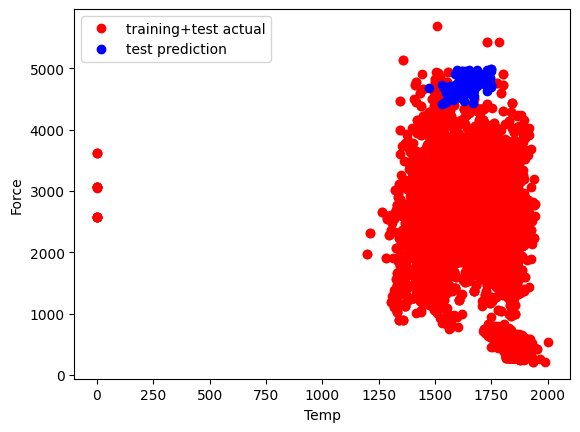

In [21]:
plt.plot(force_data['meas_exit_temp'],force_data['meas_body_force'],'ro',label='training+test actual')
plt.plot(predicted_values[:,1],predicted_values[:,0],'bo',label='test prediction')
plt.xlabel('Temp')
plt.ylabel('Force')
plt.legend()
plt.show()

In [20]:
print(test_data)

[[0.36916058 0.83608196]
 [0.36916058 0.83608196]
 [0.3879562  0.84457771]
 ...
 [0.30164234 0.85807096]
 [0.30164234 0.85807096]
 [0.13229927 0.87456272]]


### Test loss : 0.0046

- The number of epochs here is much smaller as compared to FFNs since the network is more complicated.
- Here the data is split into training and test data.
- Test loss is 0.0046 which is quite good.
- Next step would be to integrate it into finding the parameter values c1,c2, c3 and c4.